In [1]:
import findspark
findspark.init("/u/cs451/packages/spark")

from pyspark.sql import SparkSession
import random
spark = SparkSession.builder.appName("YourTest").master("local[2]").config('spark.ui.port', random.randrange(4000,5000)).getOrCreate()

In [2]:
# import libraries
from pyspark.sql.functions import *
from pyspark.sql.types import *
import matplotlib.pyplot as plt
import seaborn
import re

In [3]:
# read file
df = spark.read\
.option("wholeFile", True)\
.option("inferSchema", True)\
.option("header", True)\
.option("multiline", True)\
.option('quote', '"')\
.option('escape', '"')\
.csv("alldata.csv")

df = df.na.fill({'reviews': 0})
df = df.filter("position is not NULL")

In [4]:
# check missing values and count
df.select(*(sum(col(c).isNull().cast("int")).alias(c) for c in df.columns)).show()
df.count()

+--------+-------+-----------+-------+---------+
|
+--------+-------+-----------+-------+---------+
|       0|      0|          0|      0|        0|
+--------+-------+-----------+-------+---------+



6953

In [5]:
# divide positions into Data Scientist, Data Analyst, Engineer
df_new=df.withColumn("position2", when(lower(df["position"]).like('%scientist%') |\
                                       #lower(df["position"]).like('%science%') |\
                                       #lower(df["position"]).like('%professor%') |\
                                       lower(df["position"]).like('%science%'), lit("Data Scientist"))\
   .when(lower(df["position"]).like('%analyst%') |\
         #lower(df["position"]).like('%analysis%') |\
         lower(df["position"]).like('%analytics%') |\
         lower(df["position"]).like('%analysis%'), lit("Data Analyst"))\
   .when(lower(df["position"]).like('%engineer%'), lit("Engineer"))\
   .otherwise(lit("Others")))

In [6]:
# divide reviews into Small, Medium, Large
df_new1=df_new.withColumn("company size", when(df["reviews"] <= 50, lit("Small"))\
                          .when(df["reviews"]<= 700, lit("Medium"))\
                          .otherwise(lit("Large")))

In [7]:
# number of position categories
df_new1.select('position2').groupby('position2').count().orderBy('count', ascending=0).show()

+--------------+-----+
|     position2|count|
+--------------+-----+
|Data Scientist| 2884|
|        Others| 1925|
|      Engineer| 1151|
|  Data Analyst|  993|
+--------------+-----+



In [8]:
# number of company size
df_new1.select('company size').groupby('company size').count().orderBy('count', ascending=0).show()

+------------+-----+
|company size|count|
+------------+-----+
|       Small| 3268|
|      Medium| 1919|
|       Large| 1766|
+------------+-----+



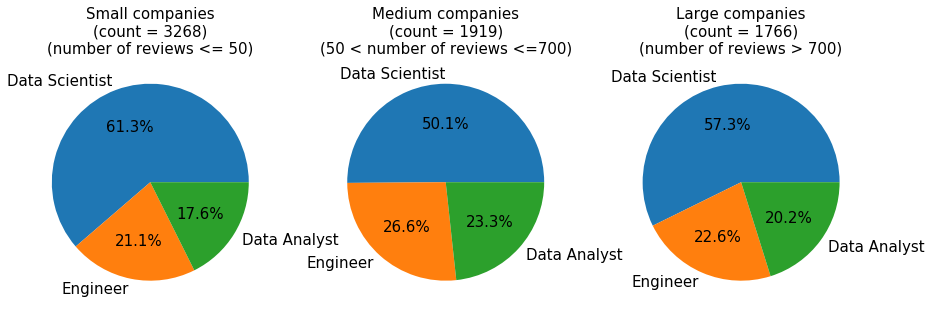

In [53]:
# unselect position2 = "Others"
df_new2=df_new1.filter(df_new["position2"] != "Others")

pandas_df1=df_new2.filter(col('company size') == 'Small')\
                    .select('position2').groupby('position2').count().orderBy('count', ascending=0).toPandas()
pandas_df2=df_new2.filter(col('company size') == 'Medium')\
                    .select('position2').groupby('position2').count().orderBy('count', ascending=0).toPandas()
pandas_df3=df_new2.filter(col('company size') == 'Large')\
                    .select('position2').groupby('position2').count().orderBy('count', ascending=0).toPandas()

# create pie chart with company size and positions
from matplotlib.gridspec import GridSpec

plt.figure(1, figsize=(15,10))
the_grid = GridSpec(2, 3)

ax=plt.subplot(the_grid[0, 0], aspect=1)
source_pie = plt.pie(pandas_df1['count'], labels=pandas_df1['position2'], autopct='%1.1f%%', textprops={'fontsize': 15})
ax.set_title('Small companies\n(count = 3268)\n(number of reviews <= 50)',fontsize= 15) 

ax=plt.subplot(the_grid[0, 1], aspect=1)
flavor_pie = plt.pie(pandas_df2['count'], labels=pandas_df2['position2'], autopct='%1.1f%%', textprops={'fontsize': 15})
ax.set_title('Medium companies\n(count = 1919)\n(50 < number of reviews <=700)',fontsize= 15) 

ax=plt.subplot(the_grid[0, 2], aspect=1)
flavor_pie = plt.pie(pandas_df3['count'], labels=pandas_df3['position2'], autopct='%1.1f%%', textprops={'fontsize': 15})
ax.set_title('Large companies\n(count = 1766)\n(number of reviews > 700)',fontsize= 15) 

#plt.suptitle('Positions in Different Size of Companies', fontsize=16)
plt.show()

# Machine Learning Classfication

In [13]:
# drop unrelated columns
drop_list = ['position', 'company', 'reviews', 'location\r', 'company size']
df_new3 = df_new2.select([column for column in df_new1.columns if column not in drop_list])
df_new3.columns

['description', 'position2']

In [14]:
from pyspark.ml.feature import Tokenizer, StopWordsRemover, CountVectorizer, HashingTF, IDF
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [23]:
add_stopwords = ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", \
                 "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", \
                 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', \
                 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', \
                 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
                 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', \
                 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', \
                 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', \
                 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', \
                 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', \
                 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', "don't", \
                 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', 've', 'y', 'ain', 'aren', "aren't", \
                 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", \
                 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn', "mustn't", 'needn', \
                 "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', \
                 "won't", 'wouldn', "wouldn't", \
                 'data', 'scientist', 'science', 'analyst', 'analysis', 'analytics', 'engineer']

In [16]:
# remove punctuation etc.
df_new3_clean = df_new3.select((lower(regexp_replace('description', "[^\w\s\/\']", "")).alias('description')))
df_new3_clean1 = df_new3_clean.select((lower(regexp_replace('description', "[^\w\s]|\n|\n\n", " ")).alias('description')))
df_new3_clean2 = df_new3_clean1.select((lower(regexp_replace('description', "\s\s+", " ")).alias('description')))

In [24]:
regexTokenizer = Tokenizer(inputCol="description", outputCol="words")
stopwordsRemover = StopWordsRemover(inputCol="words", outputCol="filtered").setStopWords(add_stopwords)

pipeline = Pipeline(stages=[regexTokenizer, stopwordsRemover])
# Fit the pipeline to training documents.
pipelineFit = pipeline.fit(df_new3_clean2)
dataset = pipelineFit.transform(df_new3_clean2)

In [56]:
# number of words
dataset.withColumn('TermFre', explode(col('filtered'))).count()

1709286

In [25]:
# number of unique words
terms=dataset.withColumn('TermFre', explode(col('filtered')))\
            .groupBy('TermFre')\
            .count()\
            .sort('count', ascending=False)

terms.count()

41841

In [40]:
dataset.columns

['position',
 'company',
 'description',
 'reviews',
 'location\r',
 'position2',
 'company size',
 'words',
 'filtered',
 'features',
 'label']

## Text Classification - Logistic Regression using Count Vector Features

In [36]:
# regular expression tokenizer
regexTokenizer = Tokenizer(inputCol="description", outputCol="words")
# stop words
stopwordsRemover = StopWordsRemover(inputCol="words", outputCol="filtered").setStopWords(add_stopwords)
# bag of words count
countVectors = CountVectorizer(inputCol="filtered", outputCol="features", vocabSize=10000, minDF=5)

label_stringIdx = StringIndexer(inputCol = "position2", outputCol = "label")
pipeline = Pipeline(stages=[regexTokenizer, stopwordsRemover, countVectors, label_stringIdx])
# Fit the pipeline to training documents.
pipelineFit = pipeline.fit(df_new2)
dataset = pipelineFit.transform(df_new2)

In [37]:
# set seed for reproducibility
(trainingData, testData) = dataset.randomSplit([0.7, 0.3], seed = 100)
print("Training Dataset Count: " + str(trainingData.count()))
print("Test Dataset Count: " + str(testData.count()))

Training Dataset Count: 3590
Test Dataset Count: 1438


In [38]:
lr = LogisticRegression(regParam=0.3)
lrModel = lr.fit(trainingData)
predictions = lrModel.transform(testData)

evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
evaluator.evaluate(predictions) #0.8051424427992571

0.8230114251615506

## Text Classification - Logistic Regression using TF-IDF Features

In [43]:
hashingTF = HashingTF(inputCol="filtered", outputCol="rawFeatures", numFeatures=10000)
idf = IDF(inputCol="rawFeatures", outputCol="features") #minDocFreq: remove sparse terms
pipeline = Pipeline(stages=[regexTokenizer, stopwordsRemover, hashingTF, idf, label_stringIdx])
pipelineFit = pipeline.fit(df_new2)
dataset = pipelineFit.transform(df_new2)

(trainingData, testData) = dataset.randomSplit([0.7, 0.3], seed = 100)
lr = LogisticRegression(regParam=0.3)
lrModel = lr.fit(trainingData)
predictions = lrModel.transform(testData)

evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
evaluator.evaluate(predictions) # 0.8003895147682552

0.8003895147682552

## Naive Bayes

In [44]:
from pyspark.ml.classification import NaiveBayes
nb = NaiveBayes(smoothing=1)
model = nb.fit(trainingData)
predictions = model.transform(testData)

evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
evaluator.evaluate(predictions)

0.7811368343893252

## Random Forest

In [45]:
from pyspark.ml.classification import RandomForestClassifier
rf = RandomForestClassifier(labelCol="label", \
                            featuresCol="features", \
                            numTrees = 100, \
                            maxDepth = 4, \
                            maxBins = 32)
# Train model with Training Data
rfModel = rf.fit(trainingData)
predictions = rfModel.transform(testData)

evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
evaluator.evaluate(predictions)

0.49142399737248554